In [1]:
from collections import Counter
import operator

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, QuantileTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

from constants import DATA_FOLDER, Files, TargetMap, TargetRevMap

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)


In [2]:
from transformers import SelectCols, BureauFeatureMapper

In [3]:
freq_map = {
    'BI-Monthly': 24/12,
    'Monthly': 12/12,
    'Quatrly': 4/12,
    'Half Yearly': 2/12
}

def bureausplit_dates(x):
    if x == '':
        return None
    if isinstance(x, float):
        return np.nan
    dates = x.split(',')
    if len(dates) == 1:
        return None
    else:
        d = dates[-2]
        return f"{d[:4]}-{d[4:6]}-{d[6:8]}"        
    

def correct_bureau_data(df):
    df["DISBURSED-DT2"] = pd.to_datetime(df["REPORTED DATE - HIST"].apply(bureausplit_dates), errors='ignore')
    return df

def get_min_date(x):
    loc = x["max_diff_loc"] + 1
    dates = str(x["REPORTED DATE - HIST"])
    if dates == 'nan':
        return "1970-01-01"
    else:
        dates = dates.split(",")[:-1][::-1]
        if len(dates) - 1 < loc:
            return dates[-1]
        min_date = dates[loc]
        return f"{min_date[:4]}-{min_date[4:6]}-{min_date[6:8]}"


def process_bal(x):
    if x == 'nan':
        return [0]
    xl = x.split(",")[:-1][::-1]
    prev_val = 0
    vals = []
    for val in xl:
        if val == '':
            val = prev_val
            vals.append(val)
        else:
            val = int(val)
            vals.append(val)
            prev_val = val
    return np.array(vals)


def get_loan_frequency(bur):
    mapping = {
        "Monthly": 12/12,
        "Quarterly": 3/12,
        "Weekly": 12*4.33/12,
        "BiWeekly": 2.16,
        "Other": -1,
        "BiMonthly": 2/12,
        "Annually": 1/12,
        "Semi annually": 6/12,
        "Single Payment Loan (bullet": 0
    }
    bur["frequency"] = bur["INSTALLMENT-AMT"].str.split("/").str.get(1).map(mapping)
    bur["installment"] = bur["INSTALLMENT-AMT"].str.split("/").str.get(0).str.replace(",", "").astype(float)
    bur["installment_pm"] = bur["installment"] * bur["frequency"]

    bur["interest"] = bur["TENURE"] * bur["installment"] * bur["frequency"]/ bur["DISBURSED-AMT/HIGH CREDIT"] 
    return bur


def read_files(data_path):
    train = pd.read_csv(Path(DATA_FOLDER) / Files.train_csv, thousands=",")
    test = pd.read_csv(Path(DATA_FOLDER) / Files.test_csv, thousands=",")
    
    train["DisbursalDate"] = pd.to_datetime(train["DisbursalDate"], errors='coerce')
    test["DisbursalDate"] = pd.to_datetime(test["DisbursalDate"], errors='coerce')

    train["MaturityDAte"] = pd.to_datetime(train["MaturityDAte"], errors='coerce')
    test["MaturityDAte"] = pd.to_datetime(test["MaturityDAte"], errors='coerce')

    train["AuthDate"] = pd.to_datetime(train["AuthDate"], errors='coerce')
    test["AuthDate"] = pd.to_datetime(test["AuthDate"], errors='coerce')

    train["Frequency"] = train["Frequency"].map(freq_map)
    test["Frequency"] = test["Frequency"].map(freq_map)

    train["days_to_enddate"] = (pd.to_datetime("2020-12-01") - train["DisbursalDate"]).dt.days
    test["days_to_enddate"] = (pd.to_datetime("2020-12-01") - test["DisbursalDate"]).dt.days

    train["days_from_start"] =  (train["DisbursalDate"] - pd.to_datetime("2010-12-01")).dt.days
    test["days_from_start"] = (test["DisbursalDate"] - pd.to_datetime("2010-12-01")).dt.days

    train_bureau = pd.read_csv(Path(DATA_FOLDER) / Files.train_bureau_csv, thousands=",")
    test_bureau = pd.read_csv(Path(DATA_FOLDER) / Files.test_bureau_csv, thousands=",")
    
    data = pd.concat([train, test])
    
    bureau = pd.concat([train_bureau, test_bureau]).reset_index(drop=True)
    bureau["DISBURSED-DT"] = pd.to_datetime(bureau["DISBURSED-DT"])
    # bureau = bureau.drop_duplicates(subset=["ID", "DISBURSED-DT"])
    bureau = bureau.sort_values(by=["ID", "DISBURSED-DT"])
    bureau = pd.merge(bureau, data[["ID", "DisbursalDate", "Tenure", "DisbursalAmount", "AssetCost", "EMI", "MonthlyIncome", "MaturityDAte", "ZiPCODE", "Area", "State"]], on="ID", how="left")
    bureau = correct_bureau_data(bureau)
    bureau.loc[bureau["DISBURSED-DT"].isnull(), "DISBURSED-DT"] = pd.to_datetime(bureau.loc[bureau["DISBURSED-DT"].isnull(), "DISBURSED-DT2"])
    bureau["post_days"] = (bureau["DISBURSED-DT"] - bureau["DisbursalDate"]).dt.days
    bureau["close_days"] = (pd.to_datetime(bureau["CLOSE-DT"], errors='coerce') - pd.to_datetime(bureau["DisbursalDate"])).dt.days
    bureau["days_to_enddate"] = (pd.to_datetime("2020-12-01") - bureau["DISBURSED-DT"]).dt.days
    bureau["post_end_days_diff"] = bureau["days_to_enddate"] - bureau["post_days"]
    bureau["post_days_diff"] = bureau.groupby("ID")["post_days"].transform(lambda x: x.duplicated(keep=False))
    bureau["cur_bal_int"] = bureau["CUR BAL - HIST"].astype(str).apply(process_bal)  # str.split(',').apply(lambda x: [int(val) if val != '' else np.nan for w, val in enumerate(x)])
    bureau["max_diff"] = bureau["cur_bal_int"].apply(lambda x:  np.diff(x).max() if len(x) > 1 else 0)
    bureau["max_diff_loc"] = bureau["cur_bal_int"].apply(lambda x:  np.argmax(np.diff(x)) if len(x) > 1 else 0)
    bureau["max_diff_date"] = pd.to_datetime(bureau[["REPORTED DATE - HIST", "max_diff_loc"]].apply(get_min_date, axis=1), errors="coerce")
    bureau["days_to_max_diff"] = (bureau["max_diff_date"] - bureau["DisbursalDate"]).dt.days
    bureau = get_loan_frequency(bureau)

    train["ACCT-TYPE"] = train.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["ACCT-TYPE"].first())
    test["ACCT-TYPE"] = test.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["ACCT-TYPE"].first())

    train["ownership"] = train.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["OWNERSHIP-IND"].first())
    test["ownership"] = test.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["OWNERSHIP-IND"].first())

    train["status"] = train.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["ACCOUNT-STATUS"].first())
    test["status"] = test.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["ACCOUNT-STATUS"].first())
    
    train["disbursed_bur"] = train.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["DISBURSED-AMT/HIGH CREDIT"].first())
    test["disbursed_bur"] = test.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["DISBURSED-AMT/HIGH CREDIT"].first())

    train["CLOSE-DT"] = pd.to_datetime(train.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["CLOSE-DT"].first()), errors='coerce')
    test["CLOSE-DT"] = pd.to_datetime(test.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["CLOSE-DT"].first()), errors='coerce')

    train["DATE-REPORTED"] = pd.to_datetime(train.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["DATE-REPORTED"].first()), errors='coerce')
    test["DATE-REPORTED"] = pd.to_datetime(test.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["DATE-REPORTED"].first()), errors='coerce')

    train["DISBURSED-DT"] = pd.to_datetime(train.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["DISBURSED-DT"].first()), errors='coerce')
    test["DISBURSED-DT"] = pd.to_datetime(test.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["DISBURSED-DT"].first()), errors='coerce')

    train["max_diff"] = train.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["max_diff"].first())
    test["max_diff"] = test.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["max_diff"].first())

    train["days_to_max_diff"] = train.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["days_to_max_diff"].first())
    test["days_to_max_diff"] = test.ID.map(bureau.loc[(bureau["SELF-INDICATOR"] == True) & (bureau["post_days"] >= 0)].groupby("ID")["days_to_max_diff"].first())

    return train, test, bureau

In [4]:
train, test, bureau = read_files(DATA_FOLDER)

In [5]:
cvlist = list(KFold(5, shuffle=True, random_state=1235786).split(train))

In [6]:
print(train.shape, test.shape, bureau.shape)

(128655, 37) (14745, 36) (624863, 50)


In [7]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


class SelectCols(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.cols]
    

class Identity(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X
    

class AsStr(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.astype(str)


class BureauFeatureMapper(BaseEstimator, TransformerMixin):
    def __init__(self, bureau_df, id_col, agg_col, filter_cond=None, agg_func=len, na_val=0):
        self.bureau_df = bureau_df
        self.id_col = id_col
        self.agg_col = agg_col
        self.filter_cond = filter_cond
        self.agg_func = agg_func
        self.na_val = na_val

        if self.filter_cond is None:
            self.filter_cond = []
        self.feature_dict = None

    def fit(self, X, y=None):
        cond = [True] * len(self.bureau_df)
        for col, value, op in self.filter_cond:
            cond &= op(self.bureau_df[col], value)
        if isinstance(self.agg_func, str):
            self.feature_dict = getattr(self.bureau_df.loc[cond].groupby(self.id_col)[self.agg_col], self.agg_func)()
        else:
            self.feature_dict = self.bureau_df.loc[cond].groupby(self.id_col)[self.agg_col].apply(self.agg_func)
        return self

    def transform(self, X, y=None):
        return X[self.id_col].map(self.feature_dict).fillna(self.na_val).values.reshape(-1, 1)
    

class TargetMapper(BaseEstimator, TransformerMixin):
    def __init__(self, grp_col, agg_col, filter_cond=None, agg_func=len, na_val=0):
        self.grp_col = grp_col
        self.agg_col = agg_col
        self.filter_cond = filter_cond
        self.agg_func = agg_func
        self.na_val = na_val

        if self.filter_cond is None:
            self.filter_cond = []
        self.feature_dict = None

    def fit(self, X, y=None):
        cond = [True] * len(X)
        for col, value, op in self.filter_cond:
            cond &= op(X[col], value)
        if isinstance(self.agg_func, str):
            self.feature_dict = getattr(X[cond].groupby(self.grp_col)[self.agg_col], self.agg_func)()
        else:
            self.feature_dict = X[cond].groupby(self.grp_col)[self.agg_col].apply(self.agg_func)
        return self

    def transform(self, X, y=None):
        return X[self.grp_col].map(self.feature_dict).fillna(self.na_val).values.reshape(-1, 1)

In [8]:
def get_next_diff(x):
    if x is None:
        return 999
    if len(x) <= 1:
        return 999
    return (x.iloc[1] - x.iloc[0]).days
        

In [9]:
train.columns, bureau.columns

(Index(['ID', 'Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode',
        'BranchID', 'Area', 'Tenure', 'AssetCost', 'AmountFinance',
        'DisbursalAmount', 'EMI', 'DisbursalDate', 'MaturityDAte', 'AuthDate',
        'AssetID', 'ManufacturerID', 'SupplierID', 'LTV', 'SEX', 'AGE',
        'MonthlyIncome', 'City', 'State', 'ZiPCODE', 'Top-up Month',
        'days_to_enddate', 'days_from_start', 'ACCT-TYPE', 'ownership',
        'status', 'disbursed_bur', 'CLOSE-DT', 'DATE-REPORTED', 'DISBURSED-DT',
        'max_diff', 'days_to_max_diff'],
       dtype='object'),
 Index(['ID', 'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
        'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT',
        'CLOSE-DT', 'LAST-PAYMENT-DATE', 'CREDIT-LIMIT/SANC AMT',
        'DISBURSED-AMT/HIGH CREDIT', 'INSTALLMENT-AMT', 'CURRENT-BAL',
        'INSTALLMENT-FREQUENCY', 'OVERDUE-AMT', 'WRITE-OFF-AMT', 'ASSET_CLASS',
        'REPORTED DATE - HIST', 'DPD - HIST', 'CUR

In [10]:
data = pd.concat([train, test])

In [11]:
train["days_to_max_diff"]

0          506.0
1          395.0
2           44.0
3         1067.0
4          389.0
           ...  
128650      40.0
128651      39.0
128652      38.0
128653      42.0
128654      31.0
Name: days_to_max_diff, Length: 128655, dtype: float64

In [102]:
# All features from train data only
pipeline1 = make_pipeline(
    make_union(
        # categorical features
        make_pipeline(
            SelectCols(["InstlmentMode", "LoanStatus", "PaymentMode", "SEX", "State", "Area", "ManufacturerID", "ACCT-TYPE", "ownership"]),
            AsStr(),
            OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=-1),
        ),
        #continous features
        make_pipeline(
            SelectCols(['Tenure', 'AssetCost', 'AmountFinance', 'DisbursalAmount', 'EMI', 'MonthlyIncome', 'AGE', 'LTV',
                        "Frequency", "days_to_enddate", 'disbursed_bur', 'days_from_start', 'days_to_max_diff', 'max_diff']),
            SimpleImputer(strategy='constant', fill_value=-1),
        ),
        # interest
        make_pipeline(
            SelectCols(["EMI", "Frequency", "Tenure", "DisbursalAmount"]),
            FunctionTransformer(lambda x: (x["EMI"] * x["Tenure"] * x["Frequency"] / x["DisbursalAmount"]).values.reshape(-1, 1))
        ),
        # normalized EMI
        make_pipeline(
            SelectCols(["EMI", "Frequency"]),
            FunctionTransformer(lambda x: (x["EMI"] * x["Frequency"]).values.reshape(-1, 1))
        ),
        # ratio of EMI to monthly income
        make_pipeline(
            SelectCols(["EMI", "MonthlyIncome", "Frequency"]),
            FunctionTransformer(lambda x: ((x["EMI"] * x["Frequency"]) / (1 + x["MonthlyIncome"])).values.reshape(-1, 1))
        ),
        make_pipeline(
            SelectCols(["MonthlyIncome", "AssetCost"]),
            FunctionTransformer(lambda x: (x["AssetCost"] / (1 + x["MonthlyIncome"])).values.reshape(-1, 1))
        ),
        make_pipeline(
            FunctionTransformer(lambda x: (x["DisbursalAmount"] - x["disbursed_bur"]).values.reshape(-1, 1))
        ),
        make_pipeline(
            FunctionTransformer(lambda x: (x["CLOSE-DT"] - x["MaturityDAte"]).dt.days.values.reshape(-1, 1))
        ),
        make_pipeline(
            FunctionTransformer(lambda x: (x["DisbursalDate"] - x["MaturityDAte"]).dt.days.values.reshape(-1, 1))
        ),
        make_pipeline(
            FunctionTransformer(lambda x: (x["DATE-REPORTED"] - x["MaturityDAte"]).dt.days.values.reshape(-1, 1))
        ),
        make_pipeline(
            FunctionTransformer(lambda x: (x["DATE-REPORTED"] - x["CLOSE-DT"]).dt.days.values.reshape(-1, 1))
        ),
        make_pipeline(
            FunctionTransformer(lambda x: (x["Tenure"] - (x["DisbursalDate"] - x["MaturityDAte"]).dt.days).values.reshape(-1, 1))
        ),
        make_pipeline(
            FunctionTransformer(lambda x: (x["DisbursalDate"] - x["CLOSE-DT"]).dt.days.values.reshape(-1, 1))
        ),
        make_pipeline(
            FunctionTransformer(lambda x: (x["days_to_enddate"] - (x["DisbursalDate"] - x["MaturityDAte"]).dt.days).values.reshape(-1, 1))
        ),    
        BureauFeatureMapper(data, "BranchID", "BranchID", None, "count"),
        BureauFeatureMapper(data, "City", "City", None, "count"),
        BureauFeatureMapper(data, "ZiPCODE", "BranchID", None, "count"),
        BureauFeatureMapper(data, "SupplierID", "MonthlyIncome", None, "mean"),
        BureauFeatureMapper(data, "City", "MonthlyIncome", None, "mean"),
        BureauFeatureMapper(data, "BranchID", "LTV", None, "mean"),
        BureauFeatureMapper(data, "SupplierID", "LTV", None, "mean"),
        BureauFeatureMapper(data, "ZiPCODE", "LTV", None, "mean"),    
        BureauFeatureMapper(data, "days_to_enddate", "ID", None, "count"),
    )
)
x1 = pipeline1.fit_transform(train)
xte1 = pipeline1.transform(test)

In [13]:
acc_cnts = bureau["ACCT-TYPE"].value_counts()
acc_to_check = acc_cnts[acc_cnts > 1000].index
acc_to_check2 = acc_cnts[acc_cnts > 10000].index

In [14]:
con_cnts = bureau["CONTRIBUTOR-TYPE"].value_counts()
contrib_to_check = con_cnts[con_cnts > 1000].index

In [15]:
acc_to_check2

Index(['Tractor Loan', 'Gold Loan',
       'Business Loan Priority Sector  Agriculture', 'Kisan Credit Card',
       'Auto Loan (Personal)', 'Other', 'Commercial Vehicle Loan',
       'Two-Wheeler Loan', 'Credit Card', 'Consumer Loan', 'Overdraft'],
      dtype='object')

In [16]:
# All counts from bureau with different combinations
tuples = [(-12, 0), (0, 12),(12, 18), (18, 24), (24, 30), (30, 36), (36, 48), (48, 480)]
pipeline2 = make_union(
    BureauFeatureMapper(bureau, "ID", "ID", None, "count"),  # loan_cnt
    BureauFeatureMapper(bureau, "ID", "ID", [("SELF-INDICATOR", True, operator.eq)], "count"),  # ltfs_loan_cnt
    BureauFeatureMapper(bureau, "ID", "ID", [("ACCOUNT-STATUS", "Active", operator.eq)], 'count'), # total active loans
    *[BureauFeatureMapper(bureau, "ID", "ID", [("OWNERSHIP-IND", owner, operator.eq)], 'count') for owner in ['Individual', 'Guarantor', 'Joint']], # total individual loans
    *[BureauFeatureMapper(bureau, "ID", "ID", [("ACCT-TYPE", acc, operator.eq)], 'count') for acc in acc_to_check],
    # *[BureauFeatureMapper(bureau, "ID", "ID", [("CONTRIBUTOR-TYPE", con, operator.eq)], 'count') for con in contrib_to_check],
    BureauFeatureMapper(bureau, "ID", "ID", [("post_days", 0, operator.gt)], "count", 999),  # loans post ltfs disbursal
    BureauFeatureMapper(bureau, "ID", "ID", [("post_days", 0, operator.gt), ("SELF-INDICATOR", True, operator.eq)], "count", 999),  # ltfs loans post ltfs disbursal
    *[BureauFeatureMapper(bureau, "ID", "ID", [("OWNERSHIP-IND", owner, operator.eq), ("post_days", 0, operator.gt)], 'count') for owner in ['Individual', 'Guarantor', 'Joint']], # total individual loans
    *[BureauFeatureMapper(bureau, "ID", "ID", [("ACCT-TYPE", acc, operator.eq), ("post_days", 0, operator.gt)], 'count') for acc in acc_to_check],
    *[BureauFeatureMapper(bureau, "ID", "ID", [("ACCT-TYPE", acc, operator.eq), ("post_days", 0, operator.lt)], 'count') for acc in acc_to_check],    
    *[BureauFeatureMapper(bureau, "ID", "ID", [("ACCT-TYPE", acc, operator.eq), ("post_days", v1*30.4, operator.gt), ("post_days", v2*30.4, operator.lt)], 'count') for (v1, v2) in tuples for acc in acc_to_check2],    
    *[BureauFeatureMapper(bureau, "ID", "ID", [("SELF-INDICATOR", True, operator.eq), ("post_days", v1*30.4, operator.gt), ("post_days", v2*30.4, operator.lt)], 'count') for (v1, v2) in tuples],
)
x2 = pipeline2.fit_transform(train)
xte2 = pipeline2.transform(test)

In [17]:
# Time deltas with bureau
pipeline3 = make_union(
    BureauFeatureMapper(bureau, "ID", "post_days", None, "last", 0),  # loan_cnt
    BureauFeatureMapper(bureau, "ID", "close_days", None, "last", 0),  # loan_cnt
    BureauFeatureMapper(bureau, "ID", "post_days", [("post_days", 0, operator.gt)], "first", 9999),  # loan_cnt
    *[BureauFeatureMapper(bureau, "ID", "post_days", [("ACCT-TYPE", acc, operator.eq), ("post_days", 0, operator.gt)], "first", 9999) for acc in acc_to_check],  # loan_cnt
    BureauFeatureMapper(bureau, "ID", "days_to_enddate", None, "last", 9999),  # loan_cnt
    BureauFeatureMapper(bureau, "ID", "days_to_enddate", None, "mean", -9999),  # average days between loans
    *[BureauFeatureMapper(bureau, "ID", "days_to_enddate", [("ACCT-TYPE", acc, operator.eq), ("post_days", 0, operator.gt)], "mean", 9999) for acc in acc_to_check2],  # loan_cnt
    *[BureauFeatureMapper(bureau, "ID", "ID", [("ACCT-TYPE", acc, operator.eq),("close_days", v1*30.4, operator.gt), ("close_days", v2*30.4, operator.lt)], 'count') for (v1, v2) in tuples for acc in acc_to_check],

)
x3 = pipeline3.fit_transform(train)
xte3 = pipeline3.transform(test)

In [18]:
# Amount stats
pipeline4 = make_union(
    BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", None, "sum", 0),  # days to next loan post ltfs loan
    BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("OWNERSHIP-IND", "Individual", operator.eq)], "sum", 0),  # days to next loan post ltfs loan
    BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("post_days", 0, operator.gt)], "sum", 0),  # days to next loan post ltfs loan
    BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("post_days", 0, operator.lt)], "sum", 0),  # days to next loan post ltfs loan
    BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("SELF-INDICATOR", True, operator.eq)], "sum", 0),  # days to next loan post ltfs loan
    *[BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("post_days", v1*30.4, operator.gt), ("post_days", v2*30.4, operator.lt)], 'sum') for (v1, v2) in tuples],
    *[BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("SELF-INDICATOR", True, operator.eq), ("post_days", v1*30.4, operator.ge), ("post_days", v2*30.4, operator.lt)], 'sum') for (v1, v2) in tuples],
    *[BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("ACCT-TYPE", acc, operator.eq), ("post_days", v1*30.4, operator.gt), ("post_days", v2*30.4, operator.lt)], 'sum') for (v1, v2) in tuples for acc in acc_to_check],
    *[BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("ACCT-TYPE", acc, operator.eq), ("post_days", v1*30.4, operator.gt), ("post_days", v2*30.4, operator.lt)], 'max') for (v1, v2) in tuples for acc in acc_to_check2],
    *[BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("ACCT-TYPE", acc, operator.eq), ("post_days", v1*30.4, operator.gt), ("post_days", v2*30.4, operator.lt)], 'min') for (v1, v2) in tuples for acc in acc_to_check2],
    *[BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("ACCT-TYPE", acc, operator.eq), ("post_days", v1*30.4, operator.gt), ("post_days", v2*30.4, operator.lt)], 'median') for (v1, v2) in tuples for acc in acc_to_check2],
    BureauFeatureMapper(bureau, "ID", "CREDIT-LIMIT/SANC AMT", [("post_days", 0, operator.lt)], "sum", 0),  # days to next loan post ltfs loan
    *[BureauFeatureMapper(bureau, "ID", "CREDIT-LIMIT/SANC AMT", [("post_days", v1*30.4, operator.gt), ("post_days", v2*30.4, operator.lt)], 'sum') for (v1, v2) in tuples],

)
x4 = pipeline4.fit_transform(train)
xte4 = pipeline4.transform(test)

In [19]:
# other params
from functools import partial
def max_overdue(x, m=12):
    if x is None:
        return 0
    dues  = 0
    for row in x.values[:1]:
        if isinstance(row, float):
            due = row
        else:
            amts = row.split(",")[:-1][::-1][:m]
            if len(amts) == 0:
                due = 0
                continue
            due = max([int(a) if (a != '') and int(a)!=0 else 0 for a in amts])
        dues += due
    return dues


def cnt_delinq(x, s=0, e=12):
    if x is None:
        return 0
    delinqs = 0
    for row in x.values:
        if isinstance(row, float):
            delin = 0
        else:
            amts = row[::-1][s:e+1]
            if len(amts) == 0:
                delin = 0
                continue
            delin = sum([1 if (a != '') and ( a !='0') and (a != 'X') else 0 for a in amts])
        delinqs += delin
    return delinqs


pipeline5 = make_union(
    BureauFeatureMapper(bureau, "ID", "CURRENT-BAL", None, "sum", 0),
    *[BureauFeatureMapper(bureau, "ID", "DPD - HIST", [("post_days", 0, operator.eq)], partial(cnt_delinq, s=v1, e=v2), 0) for (v1, v2) in tuples[1:]],
    BureauFeatureMapper(bureau, "ID", "CURRENT-BAL", None, "last", 0),
    BureauFeatureMapper(bureau, "ID", "CURRENT-BAL", [("post_days", 0, operator.eq)], "last", 0),
    BureauFeatureMapper(bureau, "ID", "OVERDUE-AMT", None, "sum", 0),
    BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("post_days_diff", True, operator.eq), ("post_days", 0, operator.le)], lambda x: (max(x) - min(x))/(1+max(x)), 0),
    BureauFeatureMapper(bureau, "ID", "post_days_diff", [("post_days", 0, operator.le)], "sum", 0),
    *[BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("post_days_diff", True, operator.eq), ("post_days", v1*30.4, operator.gt), ("post_days", v2*30.4, operator.lt)], lambda x: (max(x) - min(x))/(1+max(x)), 0) for (v1, v2) in tuples],
    *[BureauFeatureMapper(bureau, "ID", "post_days_diff", [("post_days", v1*30.4, operator.ge), ("post_days", v2*30.4, operator.lt)], "sum", 0) for (v1, v2) in tuples],
    *[BureauFeatureMapper(bureau, "ID", "ID", [("max_diff", 12000, operator.gt), ("days_to_max_diff", v1*30.4, operator.ge), ("days_to_max_diff", v2*30.4, operator.lt)], "count", 0) for (v1, v2) in tuples],
    *[BureauFeatureMapper(bureau, "ID", "max_diff", [("max_diff", 11000, operator.gt), ("days_to_max_diff", v1*30.4, operator.ge), ("days_to_max_diff", v2*30.4, operator.lt)], "min", 0) for (v1, v2) in tuples],
    # BureauFeatureMapper(bureau, "ID", "CUR BAL - HIST", [("post_days", 0, operator.eq)], lambda x: len(str(x.iloc[0]).split(",")), 0),
    # BureauFeatureMapper(bureau, "ID", "post_days", None, lambda x: x.duplicated().sum(), 0),
    # BureauFeatureMapper(bureau, "ID", "LAST-PAYMENT-DATE", None, "count", 0),
    #*[BureauFeatureMapper(bureau, "ID", "interest", [("post_days", v1*30.4, operator.gt), ("post_days", v2*30.4, operator.lt)], 'mean') for (v1, v2) in tuples],
) 
x5 = pipeline5.fit_transform(train)
xte5 = pipeline5.transform(test)

In [88]:
bureau["disburse_to_time"] = bureau["DISBURSED-AMT/HIGH CREDIT"] /(1 +  bureau["TENURE"].fillna(36))

In [97]:
pipeline6 = make_union(
    *[make_pipeline(
        make_union(
            BureauFeatureMapper(bureau, "ID", "ID", [("ACCT-TYPE", acc, operator.eq), ("post_days", 0, operator.gt)], 'count'),
            BureauFeatureMapper(bureau, "ID", "ID", [("post_days", 0, operator.gt)], 'count'),
        ),
        FunctionTransformer(lambda x: (x[:, 0]/(1 + x[:, 1])).reshape(-1, 1))
    ) for acc in acc_to_check2],
    *[make_pipeline(
        make_union(
            BureauFeatureMapper(bureau, "ID", "ID", [("post_days", 0*30.4, operator.ge), ("post_days", v2*30.4, operator.lt)], 'count'),
            BureauFeatureMapper(bureau, "ID", "ID", [("post_days", v1*30.4, operator.ge), ("post_days", v2*30.4, operator.lt)], 'count'),
        ),
        FunctionTransformer(lambda x: (x[:, 0]/(1 + x[:, 1])).reshape(-1, 1))
    ) for (v1, v2) in tuples[2:]],
    *[make_pipeline(
        make_union(
            BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("post_days", 0*30.4, operator.ge), ("post_days", v2*30.4, operator.lt)], 'sum'),
            BureauFeatureMapper(bureau, "ID", "DISBURSED-AMT/HIGH CREDIT", [("post_days", v1*30.4, operator.ge), ("post_days", v2*30.4, operator.lt)], 'sum'),
        ),
        FunctionTransformer(lambda x: (x[:, 0]/(1 + x[:, 1])).reshape(-1, 1))
    ) for (v1, v2) in tuples[2:]],

    #BureauFeatureMapper(bureau, "ID", "disburse_to_time", None, 'mean'),
    #BureauFeatureMapper(bureau, "ID", "disburse_to_time", None, 'median'),
)
x6 = pipeline6.fit_transform(train)
xte6 = pipeline6.transform(test)

In [98]:
x5[52260,-30:]

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2636e+04])

In [103]:
x = np.hstack((x1, x2, x3, x4, x5, x6))
xte = np.hstack((xte1, xte2, xte3, xte4, xte5, xte6))

x.shape

(128655, 989)

In [105]:
print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape, x6.shape)

(128655, 44) (128655, 176) (128655, 223) (128655, 478) (128655, 45) (128655, 23)


In [85]:
def ordinal_encode(x):
    if (x["Top-up Month"] == 'No Top-up Service'):
        return [0, 0, 0, 0, 0, 0]
    elif x["Top-up Month"] == '12-18 Months':
        return [1, 0, 0, 0, 0, 0]
    elif x["Top-up Month"] == '18-24 Months':
        return [1, 1, 0, 0, 0, 0]
    elif x["Top-up Month"] == '24-30 Months':
        return [1, 1, 1, 0, 0, 0]
    elif x["Top-up Month"] == '30-36 Months':
        return [1, 1, 1, 1, 0, 0]
    elif x["Top-up Month"] == '36-48 Months':
        return [1, 1, 1, 1, 1, 0]
    elif x["Top-up Month"] == ' > 48 Months':
        return [1, 1, 1, 1 ,1, 1]
    else:
        return [0, 0, 0, 0, 0, 0, 1]
    
y = np.vstack(train.apply(ordinal_encode, axis=1))
y.shape

(128655, 6)

In [108]:
import lightgbm as lgb

def process_preds(y_pred):
    ordinal_preds = []
    n = 7
    for i in range(n):
        if i == 0:
            ordinal_preds.append(1 - y_pred[:, i])
        elif i == n - 1:
            ordinal_preds.append(y_pred[:, i-1])
        else:
            ordinal_preds.append(y_pred[:, i-1] - y_pred[:, i])
    ordinal_preds = np.argmax(np.vstack(ordinal_preds).T, 1)
    return ordinal_preds

def ordinal_f1_score(y_true, y_pred, thresh=[0.9]):
    y_true = np.sum(y_true, axis=1)
    ordinal_preds = process_preds(y_pred)
    print(sum(ordinal_preds == 7))
    y_true[y_true == 7] = 0
    ordinal_preds[ordinal_preds == 7] = 0
    print(y_true, ordinal_preds)
    return f1_score(y_true, ordinal_preds, average='macro')


class MultiLabelLGBM(object):
    def __init__(self, base_models, num_targets=7):
        self.base_models = base_models
        self.num_targets = num_targets
        assert(len(self.base_models) == self.num_targets)
        
    def fit(self, xtr, ytr, xvl, yvl, *args, **kwargs):
        for i in range(self.num_targets):
            print(f"Fitting {i}th target.")
            self.base_models[i].fit(xtr, ytr[:, i], eval_set=[(xvl, yvl[:, i])], *args, **kwargs)
    
    def predict_proba(self, x):
        preds = []
        for i in range(self.num_targets):
            pred = self.base_models[i].predict_proba(x)[:, 1]
            preds.append(pred)
        return np.vstack(preds).T
            

lgb_model1 = lgb.LGBMClassifier(num_leaves=127, reg_alpha=0.0, seed=1245786, scale_pos_weight=1.2,
                           n_estimators=10000, learning_rate=0.01, subsample=0.7, colsample_bytree=0.65)
lgb_model2 = lgb.LGBMClassifier(num_leaves=63, reg_alpha=0.0, seed=1245786, scale_pos_weight=1.2,
                           n_estimators=10000, learning_rate=0.01, subsample=0.7, colsample_bytree=0.6)
lgb_model3 = lgb.LGBMClassifier(num_leaves=63, reg_alpha=0.0, seed=1245786, scale_pos_weight=1.2,
                           n_estimators=10000, learning_rate=0.01, subsample=0.7, colsample_bytree=0.6)
lgb_model4 = lgb.LGBMClassifier(num_leaves=63, reg_alpha=0.0, seed=1245786, scale_pos_weight=1.2,
                           n_estimators=10000, learning_rate=0.01, subsample=0.7, colsample_bytree=0.6)
lgb_model5 = lgb.LGBMClassifier(num_leaves=127, seed=1245786, scale_pos_weight=1.0,
                           n_estimators=10000, learning_rate=0.01, reg_alpha=0.0, subsample=0.7, colsample_bytree=0.5)
lgb_model6 = lgb.LGBMClassifier(num_leaves=127, reg_alpha=1.0, seed=1245786, scale_pos_weight=1.0,
                           n_estimators=10000, learning_rate=0.01, subsample=0.7, colsample_bytree=0.5)

model = MultiLabelLGBM([lgb_model1, lgb_model2, lgb_model3, lgb_model4, lgb_model5, lgb_model6], 6)

In [110]:
val_preds = np.zeros(shape=(len(y), 6))
test_preds = []
for i, (tr_idx, vl_idx) in enumerate(cvlist):
    xtr, xvl = x[tr_idx], x[vl_idx]
    ytr, yvl = y[tr_idx], y[vl_idx]
    model.fit(xtr, ytr, xvl, yvl, eval_metric='logloss', verbose=100, early_stopping_rounds=400,
             categorical_feature=[0, 1, 2, 3, 4, 5, 6]
             )
    vl_preds = model.predict_proba(xvl)
    print(ordinal_f1_score(yvl, vl_preds))
    val_preds[vl_idx] = vl_preds
    test_preds.append(model.predict_proba(xte))

Fitting 0th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.268561
[200]	valid_0's binary_logloss: 0.226392
[300]	valid_0's binary_logloss: 0.211207
[400]	valid_0's binary_logloss: 0.203961
[500]	valid_0's binary_logloss: 0.199328
[600]	valid_0's binary_logloss: 0.196204
[700]	valid_0's binary_logloss: 0.194186
[800]	valid_0's binary_logloss: 0.192832
[900]	valid_0's binary_logloss: 0.19198
[1000]	valid_0's binary_logloss: 0.191331
[1100]	valid_0's binary_logloss: 0.19088
[1200]	valid_0's binary_logloss: 0.190529
[1300]	valid_0's binary_logloss: 0.190234
[1400]	valid_0's binary_logloss: 0.190063
[1500]	valid_0's binary_logloss: 0.189866
[1600]	valid_0's binary_logloss: 0.189772
[1700]	valid_0's binary_logloss: 0.189749
[1800]	valid_0's binary_logloss: 0.189768
[1900]	valid_0's binary_logloss: 0.189724
[2000]	valid_0's binary_logloss: 0.18975
[2100]	valid_0's binary_logloss: 0.189827
[2200]	valid_0's binary_logloss: 0.18989
[2300]	valid_0's binary_log

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.267818
[200]	valid_0's binary_logloss: 0.227185
[300]	valid_0's binary_logloss: 0.211581
[400]	valid_0's binary_logloss: 0.2036
[500]	valid_0's binary_logloss: 0.198524
[600]	valid_0's binary_logloss: 0.195451
[700]	valid_0's binary_logloss: 0.193368
[800]	valid_0's binary_logloss: 0.192001
[900]	valid_0's binary_logloss: 0.191074
[1000]	valid_0's binary_logloss: 0.190438
[1100]	valid_0's binary_logloss: 0.189894
[1200]	valid_0's binary_logloss: 0.189454
[1300]	valid_0's binary_logloss: 0.189093
[1400]	valid_0's binary_logloss: 0.188797
[1500]	valid_0's binary_logloss: 0.188514
[1600]	valid_0's binary_logloss: 0.188287
[1700]	valid_0's binary_logloss: 0.18805
[1800]	valid_0's binary_logloss: 0.187862
[1900]	valid_0's binary_logloss: 0.187661
[2000]	valid_0's binary_logloss: 0.187532
[2100]	valid_0's binary_logloss: 0.187411
[2200]	valid_0's binary_logloss: 0.187269
[2300]	valid_0's binary_lo

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.246269
[200]	valid_0's binary_logloss: 0.208869
[300]	valid_0's binary_logloss: 0.194707
[400]	valid_0's binary_logloss: 0.187451
[500]	valid_0's binary_logloss: 0.183014
[600]	valid_0's binary_logloss: 0.180396
[700]	valid_0's binary_logloss: 0.178608
[800]	valid_0's binary_logloss: 0.177634
[900]	valid_0's binary_logloss: 0.176878
[1000]	valid_0's binary_logloss: 0.176293
[1100]	valid_0's binary_logloss: 0.175785
[1200]	valid_0's binary_logloss: 0.175393
[1300]	valid_0's binary_logloss: 0.175074
[1400]	valid_0's binary_logloss: 0.174766
[1500]	valid_0's binary_logloss: 0.174562
[1600]	valid_0's binary_logloss: 0.174315
[1700]	valid_0's binary_logloss: 0.174143
[1800]	valid_0's binary_logloss: 0.174042
[1900]	valid_0's binary_logloss: 0.173868
[2000]	valid_0's binary_logloss: 0.173703
[2100]	valid_0's binary_logloss: 0.173619
[2200]	valid_0's binary_logloss: 0.173565
[2300]	valid_0's binary

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.207569
[200]	valid_0's binary_logloss: 0.175289
[300]	valid_0's binary_logloss: 0.163172
[400]	valid_0's binary_logloss: 0.157109
[500]	valid_0's binary_logloss: 0.15359
[600]	valid_0's binary_logloss: 0.151492
[700]	valid_0's binary_logloss: 0.150132
[800]	valid_0's binary_logloss: 0.149308
[900]	valid_0's binary_logloss: 0.148737
[1000]	valid_0's binary_logloss: 0.14834
[1100]	valid_0's binary_logloss: 0.148005
[1200]	valid_0's binary_logloss: 0.14778
[1300]	valid_0's binary_logloss: 0.147515
[1400]	valid_0's binary_logloss: 0.147323
[1500]	valid_0's binary_logloss: 0.147179
[1600]	valid_0's binary_logloss: 0.147046
[1700]	valid_0's binary_logloss: 0.146904
[1800]	valid_0's binary_logloss: 0.14684
[1900]	valid_0's binary_logloss: 0.146755
[2000]	valid_0's binary_logloss: 0.14672
[2100]	valid_0's binary_logloss: 0.146699
[2200]	valid_0's binary_logloss: 0.146737
[2300]	valid_0's binary_logl

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.167868
[200]	valid_0's binary_logloss: 0.139698
[300]	valid_0's binary_logloss: 0.129393
[400]	valid_0's binary_logloss: 0.124858
[500]	valid_0's binary_logloss: 0.122149
[600]	valid_0's binary_logloss: 0.120705
[700]	valid_0's binary_logloss: 0.119823
[800]	valid_0's binary_logloss: 0.119299
[900]	valid_0's binary_logloss: 0.119079
[1000]	valid_0's binary_logloss: 0.118981
[1100]	valid_0's binary_logloss: 0.119003
[1200]	valid_0's binary_logloss: 0.119188
[1300]	valid_0's binary_logloss: 0.119432
Early stopping, best iteration is:
[995]	valid_0's binary_logloss: 0.118969
Fitting 5th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.118349
[200]	valid_0's binary_logloss: 0.0964716
[300]	valid_0's binary_logloss: 0.0886225
[400]	valid_0's binary_logloss: 0.0855056
[500]	valid_0's binary_logloss: 0.0839625
[600]	valid_0's binary_logloss: 0.0831738
[700]	valid_0's binary_logloss: 0.082803
[800]	valid_0's binary_logloss: 0.0827062
[900]	valid_0's binary_logloss: 0.0828056
[1000]	valid_0's binary_logloss: 0.0830324
[1100]	valid_0's binary_logloss: 0.0833207
Early stopping, best iteration is:
[794]	valid_0's binary_logloss: 0.0826997
0
[5 0 0 ... 0 0 0] [5 0 0 ... 0 0 0]
0.7507150328917457
Fitting 0th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.271957
[200]	valid_0's binary_logloss: 0.231477
[300]	valid_0's binary_logloss: 0.216617
[400]	valid_0's binary_logloss: 0.209505
[500]	valid_0's binary_logloss: 0.205053
[600]	valid_0's binary_logloss: 0.202112
[700]	valid_0's binary_logloss: 0.200501
[800]	valid_0's binary_logloss: 0.199366
[900]	valid_0's binary_logloss: 0.198581
[1000]	valid_0's binary_logloss: 0.198163
[1100]	valid_0's binary_logloss: 0.197806
[1200]	valid_0's binary_logloss: 0.197596
[1300]	valid_0's binary_logloss: 0.197443
[1400]	valid_0's binary_logloss: 0.197308
[1500]	valid_0's binary_logloss: 0.197179
[1600]	valid_0's binary_logloss: 0.197122
[1700]	valid_0's binary_logloss: 0.197102
[1800]	valid_0's binary_logloss: 0.197186
[1900]	valid_0's binary_logloss: 0.197266
[2000]	valid_0's binary_logloss: 0.197431
Early stopping, best iteration is:
[1640]	valid_0's binary_logloss: 0.197081
Fitting 1th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.271492
[200]	valid_0's binary_logloss: 0.232618
[300]	valid_0's binary_logloss: 0.21745
[400]	valid_0's binary_logloss: 0.209684
[500]	valid_0's binary_logloss: 0.204592
[600]	valid_0's binary_logloss: 0.201371
[700]	valid_0's binary_logloss: 0.199389
[800]	valid_0's binary_logloss: 0.19813
[900]	valid_0's binary_logloss: 0.197356
[1000]	valid_0's binary_logloss: 0.196791
[1100]	valid_0's binary_logloss: 0.196322
[1200]	valid_0's binary_logloss: 0.195904
[1300]	valid_0's binary_logloss: 0.19556
[1400]	valid_0's binary_logloss: 0.195316
[1500]	valid_0's binary_logloss: 0.195032
[1600]	valid_0's binary_logloss: 0.194821
[1700]	valid_0's binary_logloss: 0.1946
[1800]	valid_0's binary_logloss: 0.194477
[1900]	valid_0's binary_logloss: 0.194355
[2000]	valid_0's binary_logloss: 0.194191
[2100]	valid_0's binary_logloss: 0.194079
[2200]	valid_0's binary_logloss: 0.193969
[2300]	valid_0's binary_logl

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.24996
[200]	valid_0's binary_logloss: 0.214691
[300]	valid_0's binary_logloss: 0.201121
[400]	valid_0's binary_logloss: 0.1941
[500]	valid_0's binary_logloss: 0.189861
[600]	valid_0's binary_logloss: 0.187309
[700]	valid_0's binary_logloss: 0.185774
[800]	valid_0's binary_logloss: 0.184853
[900]	valid_0's binary_logloss: 0.184208
[1000]	valid_0's binary_logloss: 0.183803
[1100]	valid_0's binary_logloss: 0.183452
[1200]	valid_0's binary_logloss: 0.183149
[1300]	valid_0's binary_logloss: 0.18295
[1400]	valid_0's binary_logloss: 0.182764
[1500]	valid_0's binary_logloss: 0.182589
[1600]	valid_0's binary_logloss: 0.182455
[1700]	valid_0's binary_logloss: 0.18234
[1800]	valid_0's binary_logloss: 0.182242
[1900]	valid_0's binary_logloss: 0.182158
[2000]	valid_0's binary_logloss: 0.18209
[2100]	valid_0's binary_logloss: 0.182011
[2200]	valid_0's binary_logloss: 0.18201
[2300]	valid_0's binary_loglos

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.208905
[200]	valid_0's binary_logloss: 0.178462
[300]	valid_0's binary_logloss: 0.167045
[400]	valid_0's binary_logloss: 0.161377
[500]	valid_0's binary_logloss: 0.158174
[600]	valid_0's binary_logloss: 0.156229
[700]	valid_0's binary_logloss: 0.155127
[800]	valid_0's binary_logloss: 0.154485
[900]	valid_0's binary_logloss: 0.154043
[1000]	valid_0's binary_logloss: 0.153749
[1100]	valid_0's binary_logloss: 0.153523
[1200]	valid_0's binary_logloss: 0.153388
[1300]	valid_0's binary_logloss: 0.153165
[1400]	valid_0's binary_logloss: 0.153073
[1500]	valid_0's binary_logloss: 0.153011
[1600]	valid_0's binary_logloss: 0.152922
[1700]	valid_0's binary_logloss: 0.152895
[1800]	valid_0's binary_logloss: 0.152891
[1900]	valid_0's binary_logloss: 0.152842
[2000]	valid_0's binary_logloss: 0.152792
[2100]	valid_0's binary_logloss: 0.152854
[2200]	valid_0's binary_logloss: 0.152933
[2300]	valid_0's binary

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.169786
[200]	valid_0's binary_logloss: 0.142479
[300]	valid_0's binary_logloss: 0.132666
[400]	valid_0's binary_logloss: 0.128216
[500]	valid_0's binary_logloss: 0.126118
[600]	valid_0's binary_logloss: 0.124951
[700]	valid_0's binary_logloss: 0.124238
[800]	valid_0's binary_logloss: 0.124043
[900]	valid_0's binary_logloss: 0.123929
[1000]	valid_0's binary_logloss: 0.124037
[1100]	valid_0's binary_logloss: 0.124228
[1200]	valid_0's binary_logloss: 0.124449
Early stopping, best iteration is:
[896]	valid_0's binary_logloss: 0.12392
Fitting 5th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.123856
[200]	valid_0's binary_logloss: 0.102645
[300]	valid_0's binary_logloss: 0.0951122
[400]	valid_0's binary_logloss: 0.0920113
[500]	valid_0's binary_logloss: 0.090629
[600]	valid_0's binary_logloss: 0.0900264
[700]	valid_0's binary_logloss: 0.0898826
[800]	valid_0's binary_logloss: 0.0900035
[900]	valid_0's binary_logloss: 0.0902791
[1000]	valid_0's binary_logloss: 0.0906755
[1100]	valid_0's binary_logloss: 0.0912373
Early stopping, best iteration is:
[726]	valid_0's binary_logloss: 0.0898632
0
[0 0 0 ... 0 0 0] [0 0 0 ... 0 0 0]
0.7449874095880229
Fitting 0th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.268439
[200]	valid_0's binary_logloss: 0.229292
[300]	valid_0's binary_logloss: 0.214953
[400]	valid_0's binary_logloss: 0.207985
[500]	valid_0's binary_logloss: 0.203657
[600]	valid_0's binary_logloss: 0.200674
[700]	valid_0's binary_logloss: 0.198841
[800]	valid_0's binary_logloss: 0.197523
[900]	valid_0's binary_logloss: 0.19682
[1000]	valid_0's binary_logloss: 0.196344
[1100]	valid_0's binary_logloss: 0.195926
[1200]	valid_0's binary_logloss: 0.195626
[1300]	valid_0's binary_logloss: 0.195388
[1400]	valid_0's binary_logloss: 0.19522
[1500]	valid_0's binary_logloss: 0.19509
[1600]	valid_0's binary_logloss: 0.194968
[1700]	valid_0's binary_logloss: 0.194935
[1800]	valid_0's binary_logloss: 0.194876
[1900]	valid_0's binary_logloss: 0.195039
[2000]	valid_0's binary_logloss: 0.195215
[2100]	valid_0's binary_logloss: 0.19534
Early stopping, best iteration is:
[1774]	valid_0's binary_logloss: 0

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.267154
[200]	valid_0's binary_logloss: 0.229347
[300]	valid_0's binary_logloss: 0.214748
[400]	valid_0's binary_logloss: 0.207231
[500]	valid_0's binary_logloss: 0.202266
[600]	valid_0's binary_logloss: 0.199233
[700]	valid_0's binary_logloss: 0.197184
[800]	valid_0's binary_logloss: 0.195884
[900]	valid_0's binary_logloss: 0.195054
[1000]	valid_0's binary_logloss: 0.194436
[1100]	valid_0's binary_logloss: 0.194038
[1200]	valid_0's binary_logloss: 0.1936
[1300]	valid_0's binary_logloss: 0.193238
[1400]	valid_0's binary_logloss: 0.192962
[1500]	valid_0's binary_logloss: 0.192676
[1600]	valid_0's binary_logloss: 0.192434
[1700]	valid_0's binary_logloss: 0.192227
[1800]	valid_0's binary_logloss: 0.192042
[1900]	valid_0's binary_logloss: 0.191925
[2000]	valid_0's binary_logloss: 0.191759
[2100]	valid_0's binary_logloss: 0.191659
[2200]	valid_0's binary_logloss: 0.191578
[2300]	valid_0's binary_l

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.245881
[200]	valid_0's binary_logloss: 0.21152
[300]	valid_0's binary_logloss: 0.197747
[400]	valid_0's binary_logloss: 0.191155
[500]	valid_0's binary_logloss: 0.187063
[600]	valid_0's binary_logloss: 0.184504
[700]	valid_0's binary_logloss: 0.182955
[800]	valid_0's binary_logloss: 0.181901
[900]	valid_0's binary_logloss: 0.181174
[1000]	valid_0's binary_logloss: 0.180527
[1100]	valid_0's binary_logloss: 0.180058
[1200]	valid_0's binary_logloss: 0.179721
[1300]	valid_0's binary_logloss: 0.17934
[1400]	valid_0's binary_logloss: 0.179054
[1500]	valid_0's binary_logloss: 0.178736
[1600]	valid_0's binary_logloss: 0.178567
[1700]	valid_0's binary_logloss: 0.17831
[1800]	valid_0's binary_logloss: 0.178105
[1900]	valid_0's binary_logloss: 0.177952
[2000]	valid_0's binary_logloss: 0.177894
[2100]	valid_0's binary_logloss: 0.177781
[2200]	valid_0's binary_logloss: 0.177728
[2300]	valid_0's binary_lo

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.205552
[200]	valid_0's binary_logloss: 0.174997
[300]	valid_0's binary_logloss: 0.163608
[400]	valid_0's binary_logloss: 0.15789
[500]	valid_0's binary_logloss: 0.15462
[600]	valid_0's binary_logloss: 0.152729
[700]	valid_0's binary_logloss: 0.151625
[800]	valid_0's binary_logloss: 0.150878
[900]	valid_0's binary_logloss: 0.150318
[1000]	valid_0's binary_logloss: 0.149911
[1100]	valid_0's binary_logloss: 0.149562
[1200]	valid_0's binary_logloss: 0.149227
[1300]	valid_0's binary_logloss: 0.148935
[1400]	valid_0's binary_logloss: 0.148688
[1500]	valid_0's binary_logloss: 0.148504
[1600]	valid_0's binary_logloss: 0.148353
[1700]	valid_0's binary_logloss: 0.148197
[1800]	valid_0's binary_logloss: 0.148135
[1900]	valid_0's binary_logloss: 0.148094
[2000]	valid_0's binary_logloss: 0.148067
[2100]	valid_0's binary_logloss: 0.148017
[2200]	valid_0's binary_logloss: 0.14794
[2300]	valid_0's binary_lo

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.166968
[200]	valid_0's binary_logloss: 0.14017
[300]	valid_0's binary_logloss: 0.130652
[400]	valid_0's binary_logloss: 0.126225
[500]	valid_0's binary_logloss: 0.12388
[600]	valid_0's binary_logloss: 0.122582
[700]	valid_0's binary_logloss: 0.121873
[800]	valid_0's binary_logloss: 0.121475
[900]	valid_0's binary_logloss: 0.121278
[1000]	valid_0's binary_logloss: 0.121294
[1100]	valid_0's binary_logloss: 0.121437
[1200]	valid_0's binary_logloss: 0.121612
[1300]	valid_0's binary_logloss: 0.121886
Early stopping, best iteration is:
[934]	valid_0's binary_logloss: 0.121229
Fitting 5th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.116044
[200]	valid_0's binary_logloss: 0.094625
[300]	valid_0's binary_logloss: 0.0868666
[400]	valid_0's binary_logloss: 0.0834919
[500]	valid_0's binary_logloss: 0.081985
[600]	valid_0's binary_logloss: 0.0811647
[700]	valid_0's binary_logloss: 0.0807723
[800]	valid_0's binary_logloss: 0.0805814
[900]	valid_0's binary_logloss: 0.0806198
[1000]	valid_0's binary_logloss: 0.080714
[1100]	valid_0's binary_logloss: 0.080933
Early stopping, best iteration is:
[793]	valid_0's binary_logloss: 0.0805801
0
[1 0 0 ... 0 0 0] [1 0 0 ... 0 0 0]
0.7414760174844578
Fitting 0th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.271673
[200]	valid_0's binary_logloss: 0.230878
[300]	valid_0's binary_logloss: 0.216091
[400]	valid_0's binary_logloss: 0.208953
[500]	valid_0's binary_logloss: 0.204559
[600]	valid_0's binary_logloss: 0.201792
[700]	valid_0's binary_logloss: 0.200034
[800]	valid_0's binary_logloss: 0.198878
[900]	valid_0's binary_logloss: 0.198265
[1000]	valid_0's binary_logloss: 0.19781
[1100]	valid_0's binary_logloss: 0.197513
[1200]	valid_0's binary_logloss: 0.197313
[1300]	valid_0's binary_logloss: 0.197151
[1400]	valid_0's binary_logloss: 0.196988
[1500]	valid_0's binary_logloss: 0.196963
[1600]	valid_0's binary_logloss: 0.196916
[1700]	valid_0's binary_logloss: 0.196935
[1800]	valid_0's binary_logloss: 0.197026
[1900]	valid_0's binary_logloss: 0.197245
Early stopping, best iteration is:
[1562]	valid_0's binary_logloss: 0.196897
Fitting 1th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.271651
[200]	valid_0's binary_logloss: 0.23261
[300]	valid_0's binary_logloss: 0.21754
[400]	valid_0's binary_logloss: 0.209731
[500]	valid_0's binary_logloss: 0.204777
[600]	valid_0's binary_logloss: 0.201703
[700]	valid_0's binary_logloss: 0.19995
[800]	valid_0's binary_logloss: 0.198792
[900]	valid_0's binary_logloss: 0.197988
[1000]	valid_0's binary_logloss: 0.197458
[1100]	valid_0's binary_logloss: 0.197037
[1200]	valid_0's binary_logloss: 0.196635
[1300]	valid_0's binary_logloss: 0.196378
[1400]	valid_0's binary_logloss: 0.196169
[1500]	valid_0's binary_logloss: 0.195954
[1600]	valid_0's binary_logloss: 0.19571
[1700]	valid_0's binary_logloss: 0.195552
[1800]	valid_0's binary_logloss: 0.195397
[1900]	valid_0's binary_logloss: 0.195328
[2000]	valid_0's binary_logloss: 0.195178
[2100]	valid_0's binary_logloss: 0.195017
[2200]	valid_0's binary_logloss: 0.194881
[2300]	valid_0's binary_log

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.247929
[200]	valid_0's binary_logloss: 0.212277
[300]	valid_0's binary_logloss: 0.198306
[400]	valid_0's binary_logloss: 0.191356
[500]	valid_0's binary_logloss: 0.187048
[600]	valid_0's binary_logloss: 0.184491
[700]	valid_0's binary_logloss: 0.183035
[800]	valid_0's binary_logloss: 0.182093
[900]	valid_0's binary_logloss: 0.18147
[1000]	valid_0's binary_logloss: 0.180981
[1100]	valid_0's binary_logloss: 0.180586
[1200]	valid_0's binary_logloss: 0.180252
[1300]	valid_0's binary_logloss: 0.179993
[1400]	valid_0's binary_logloss: 0.179798
[1500]	valid_0's binary_logloss: 0.179626
[1600]	valid_0's binary_logloss: 0.179413
[1700]	valid_0's binary_logloss: 0.179267
[1800]	valid_0's binary_logloss: 0.17919
[1900]	valid_0's binary_logloss: 0.179069
[2000]	valid_0's binary_logloss: 0.178981
[2100]	valid_0's binary_logloss: 0.178889
[2200]	valid_0's binary_logloss: 0.178772
[2300]	valid_0's binary_l

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.207091
[200]	valid_0's binary_logloss: 0.175072
[300]	valid_0's binary_logloss: 0.163178
[400]	valid_0's binary_logloss: 0.157205
[500]	valid_0's binary_logloss: 0.153712
[600]	valid_0's binary_logloss: 0.151824
[700]	valid_0's binary_logloss: 0.150769
[800]	valid_0's binary_logloss: 0.149945
[900]	valid_0's binary_logloss: 0.14946
[1000]	valid_0's binary_logloss: 0.149092
[1100]	valid_0's binary_logloss: 0.148735
[1200]	valid_0's binary_logloss: 0.148522
[1300]	valid_0's binary_logloss: 0.148264
[1400]	valid_0's binary_logloss: 0.148091
[1500]	valid_0's binary_logloss: 0.147991
[1600]	valid_0's binary_logloss: 0.147868
[1700]	valid_0's binary_logloss: 0.147761
[1800]	valid_0's binary_logloss: 0.147694
[1900]	valid_0's binary_logloss: 0.147538
[2000]	valid_0's binary_logloss: 0.147517
[2100]	valid_0's binary_logloss: 0.147508
[2200]	valid_0's binary_logloss: 0.147479
[2300]	valid_0's binary_

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.170653
[200]	valid_0's binary_logloss: 0.142455
[300]	valid_0's binary_logloss: 0.132211
[400]	valid_0's binary_logloss: 0.127405
[500]	valid_0's binary_logloss: 0.125099
[600]	valid_0's binary_logloss: 0.123805
[700]	valid_0's binary_logloss: 0.123207
[800]	valid_0's binary_logloss: 0.122954
[900]	valid_0's binary_logloss: 0.122787
[1000]	valid_0's binary_logloss: 0.122872
[1100]	valid_0's binary_logloss: 0.122974
[1200]	valid_0's binary_logloss: 0.123307
[1300]	valid_0's binary_logloss: 0.12366
Early stopping, best iteration is:
[959]	valid_0's binary_logloss: 0.122773
Fitting 5th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.12183
[200]	valid_0's binary_logloss: 0.09957
[300]	valid_0's binary_logloss: 0.0918494
[400]	valid_0's binary_logloss: 0.0885067
[500]	valid_0's binary_logloss: 0.0869936
[600]	valid_0's binary_logloss: 0.086338
[700]	valid_0's binary_logloss: 0.0861121
[800]	valid_0's binary_logloss: 0.0862225
[900]	valid_0's binary_logloss: 0.0865129
[1000]	valid_0's binary_logloss: 0.0869152
[1100]	valid_0's binary_logloss: 0.0873244
Early stopping, best iteration is:
[707]	valid_0's binary_logloss: 0.0860982
0
[6 0 0 ... 0 1 0] [6 0 0 ... 0 0 0]
0.7346067832035438
Fitting 0th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.270142
[200]	valid_0's binary_logloss: 0.229808
[300]	valid_0's binary_logloss: 0.214625
[400]	valid_0's binary_logloss: 0.207537
[500]	valid_0's binary_logloss: 0.203045
[600]	valid_0's binary_logloss: 0.200363
[700]	valid_0's binary_logloss: 0.198785
[800]	valid_0's binary_logloss: 0.197787
[900]	valid_0's binary_logloss: 0.197085
[1000]	valid_0's binary_logloss: 0.196578
[1100]	valid_0's binary_logloss: 0.196254
[1200]	valid_0's binary_logloss: 0.195937
[1300]	valid_0's binary_logloss: 0.195718
[1400]	valid_0's binary_logloss: 0.195587
[1500]	valid_0's binary_logloss: 0.195546
[1600]	valid_0's binary_logloss: 0.195599
[1700]	valid_0's binary_logloss: 0.195602
[1800]	valid_0's binary_logloss: 0.195712
Early stopping, best iteration is:
[1483]	valid_0's binary_logloss: 0.195514
Fitting 1th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.269918
[200]	valid_0's binary_logloss: 0.231143
[300]	valid_0's binary_logloss: 0.216061
[400]	valid_0's binary_logloss: 0.208526
[500]	valid_0's binary_logloss: 0.203359
[600]	valid_0's binary_logloss: 0.200228
[700]	valid_0's binary_logloss: 0.198156
[800]	valid_0's binary_logloss: 0.196887
[900]	valid_0's binary_logloss: 0.196067
[1000]	valid_0's binary_logloss: 0.195419
[1100]	valid_0's binary_logloss: 0.194897
[1200]	valid_0's binary_logloss: 0.19449
[1300]	valid_0's binary_logloss: 0.194179
[1400]	valid_0's binary_logloss: 0.193888
[1500]	valid_0's binary_logloss: 0.193658
[1600]	valid_0's binary_logloss: 0.19351
[1700]	valid_0's binary_logloss: 0.193334
[1800]	valid_0's binary_logloss: 0.193196
[1900]	valid_0's binary_logloss: 0.193134
[2000]	valid_0's binary_logloss: 0.193061
[2100]	valid_0's binary_logloss: 0.192959
[2200]	valid_0's binary_logloss: 0.192898
[2300]	valid_0's binary_l

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.246855
[200]	valid_0's binary_logloss: 0.211532
[300]	valid_0's binary_logloss: 0.197786
[400]	valid_0's binary_logloss: 0.190604
[500]	valid_0's binary_logloss: 0.186153
[600]	valid_0's binary_logloss: 0.183739
[700]	valid_0's binary_logloss: 0.182198
[800]	valid_0's binary_logloss: 0.181265
[900]	valid_0's binary_logloss: 0.180561
[1000]	valid_0's binary_logloss: 0.180111
[1100]	valid_0's binary_logloss: 0.179712
[1200]	valid_0's binary_logloss: 0.179335
[1300]	valid_0's binary_logloss: 0.178886
[1400]	valid_0's binary_logloss: 0.178637
[1500]	valid_0's binary_logloss: 0.178365
[1600]	valid_0's binary_logloss: 0.178144
[1700]	valid_0's binary_logloss: 0.17803
[1800]	valid_0's binary_logloss: 0.17783
[1900]	valid_0's binary_logloss: 0.177692
[2000]	valid_0's binary_logloss: 0.177544
[2100]	valid_0's binary_logloss: 0.177466
[2200]	valid_0's binary_logloss: 0.17744
[2300]	valid_0's binary_lo

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.206413
[200]	valid_0's binary_logloss: 0.175441
[300]	valid_0's binary_logloss: 0.163788
[400]	valid_0's binary_logloss: 0.157829
[500]	valid_0's binary_logloss: 0.15423
[600]	valid_0's binary_logloss: 0.152323
[700]	valid_0's binary_logloss: 0.151181
[800]	valid_0's binary_logloss: 0.150485
[900]	valid_0's binary_logloss: 0.149871
[1000]	valid_0's binary_logloss: 0.149503
[1100]	valid_0's binary_logloss: 0.14915
[1200]	valid_0's binary_logloss: 0.148895
[1300]	valid_0's binary_logloss: 0.148631
[1400]	valid_0's binary_logloss: 0.148426
[1500]	valid_0's binary_logloss: 0.148288
[1600]	valid_0's binary_logloss: 0.148162
[1700]	valid_0's binary_logloss: 0.1481
[1800]	valid_0's binary_logloss: 0.148046
[1900]	valid_0's binary_logloss: 0.148014
[2000]	valid_0's binary_logloss: 0.147898
[2100]	valid_0's binary_logloss: 0.147855
[2200]	valid_0's binary_logloss: 0.147774
[2300]	valid_0's binary_log

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.168535
[200]	valid_0's binary_logloss: 0.141276
[300]	valid_0's binary_logloss: 0.13143
[400]	valid_0's binary_logloss: 0.126995
[500]	valid_0's binary_logloss: 0.124514
[600]	valid_0's binary_logloss: 0.123241
[700]	valid_0's binary_logloss: 0.122639
[800]	valid_0's binary_logloss: 0.122436
[900]	valid_0's binary_logloss: 0.12234
[1000]	valid_0's binary_logloss: 0.122378
[1100]	valid_0's binary_logloss: 0.122487
[1200]	valid_0's binary_logloss: 0.122737
[1300]	valid_0's binary_logloss: 0.123092
Early stopping, best iteration is:
[975]	valid_0's binary_logloss: 0.122324
Fitting 5th target.


/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
[100]	valid_0's binary_logloss: 0.118391
[200]	valid_0's binary_logloss: 0.095988
[300]	valid_0's binary_logloss: 0.0879243
[400]	valid_0's binary_logloss: 0.0847157
[500]	valid_0's binary_logloss: 0.0831018
[600]	valid_0's binary_logloss: 0.0823053
[700]	valid_0's binary_logloss: 0.0820367
[800]	valid_0's binary_logloss: 0.082048
[900]	valid_0's binary_logloss: 0.0822169
[1000]	valid_0's binary_logloss: 0.0824676
[1100]	valid_0's binary_logloss: 0.0827911
Early stopping, best iteration is:
[769]	valid_0's binary_logloss: 0.0820052
0
[6 0 0 ... 2 2 3] [6 0 0 ... 0 0 0]
0.7427302183373714


In [111]:
y.sum(0)/len(y)

array([0.17082896, 0.16279196, 0.14438615, 0.11724379, 0.09344371,
       0.06502662])

In [112]:
bureau.head(50)

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE,DisbursalDate,Tenure,DisbursalAmount,AssetCost,EMI,MonthlyIncome,MaturityDAte,ZiPCODE,Area,State,DISBURSED-DT2,post_days,close_days,days_to_enddate,post_end_days_diff,post_days_diff,cur_bal_int,max_diff,max_diff_loc,max_diff_date,days_to_max_diff,frequency,installment,installment_pm,interest,disburse_to_time
0,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,NaN,NaN,275000.0,NaN,0.0,NaN,0.0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,2012-02-10,48,275000.0,450000,24000.0,35833.33,2016-01-15,464993.0,NaN,MADHYA PRADESH,2013-03-31,0.0,1452.0,3217.0,3217.0,False,"[226605, 205875, 208846, 211860, 190917, 19367...",3014,2,2013-06-30,506.0,NaN,NaN,NaN,NaN,7432.432432
1,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-01-30,2017-09-21 00:00:00,NaN,NaN,500000.0,NaN,0.0,NaN,0.0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0000000000000870540270270000320000000000...,"0,,0,0,0,0,0,0,0,13060,13060,25982,38767,51417...","0,,0,0,0,0,3064,3064,3064,2972,0,2802,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,2012-02-10,48,275000.0,450000,24000.0,35833.33,2016-01-15,464993.0,NaN,MADHYA PRADESH,2014-10-31,355.0,2050.0,2862.0,2507.0,False,"[308149, 298244, 288233, 278115, 267889, 25755...",0,25,2016-12-31,1786.0,NaN,NaN,NaN,NaN,13513.513514
2,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-07-31,Individual,Closed,2013-06-11,2017-07-01 00:00:00,NaN,NaN,400000.0,NaN,0.0,NaN,0.0,0.0,NaN,"20170731,20170601,20170531,20170430,20170331,2...",000DDD0220210220190220220000270000000000000000...,"0,,0,10487,20862,31126,41281,51328,51328,71101...","0,,1722,1722,1722,1722,1722,1722,0,1625,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,2012-02-10,48,275000.0,450000,24000.0,35833.33,2016-01-15,464993.0,NaN,MADHYA PRADESH,2014-08-31,487.0,1968.0,2730.0,2243.0,False,"[293040, 285599, 278077, 270475, 262790, 25502...",0,25,2016-10-31,1725.0,NaN,NaN,NaN,NaN,10810.810811
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,NaN,NaN,300000.0,NaN,0.0,NaN,0.0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,2012-02-10,48,275000.0,450000,24000.0,35833.33,2016-01-15,464993.0,NaN,MADHYA PRADESH,2014-10-31,595.0,2050.0,2622.0,2027.0,False,"[232582, 227140, 221636, 216069, 210438, 20474...",0,25,2016-12-31,1786.0,NaN,NaN,NaN,NaN,8108.108108
4,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,37352.0,NaN,37873.0,NaN,37873.0,0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN,2012-02-10,48,275000.0,450000,24000.0,35833.33,2016-01-15,464993.0,NaN,MADHYA PRADESH,2018-03-31,1333.0,NaN,1884.0,551.0,False,"[12820, 37873]",25053,0,2018-04-30,2271.0,NaN,NaN,NaN,NaN,1009.513514
5,1,False,PRIMARY,Credit Card,NAB,2018-04-30,Individual,Closed,2018-01-11,2018-03-13 00:00:00,NaN,50000.0,0.0,NaN,0.0,NaN,NaN,0.0,Standard,"20180331,20180228,20180131,",000000000,"24650,17300,0,",",,,",",,,,",NaN,2012-02-10,48,275000.0,450000,24000.0,35833.33,2016-01-15,464993.0,NaN,MADHYA PRADESH,2018-01-31,2162.0,2223.0,1055.0,-1107.0,False,"[0, 17300, 24650]",17300,0,2018-02-28,2210.0,NaN,NaN,NaN,NaN,0.000000
6,1,False,PR

In [113]:
test_preds_mean = np.mean(test_preds, 0)

In [114]:
np.save("data/val_preds_lgb6.npy", val_preds)
np.save("data/test_preds_mean_lgb6.npy", test_preds_mean)

In [115]:
val_preds = np.load("data/val_preds_lgb6.npy")
test_preds_mean = np.load("data/test_preds_mean_lgb6.npy")
ordinal_f1_score(y, val_preds)

0
[6 0 1 ... 0 0 0] [6 0 1 ... 0 0 0]


0.7430409375210827

In [135]:
val_preds3 = np.load("data/val_preds_lgb3.npy")
test_preds_mean3 = np.load("data/test_preds_mean_lgb3.npy")

val_preds4 = np.load("data/val_preds_lgb4.npy")
test_preds_mean4 = np.load("data/test_preds_mean_lgb4.npy")

val_preds5 = np.load("data/val_preds_lgb5.npy")
test_preds_mean5 = np.load("data/test_preds_mean_lgb5.npy")

val_preds22 = np.load("data/val_preds_lgb22.npy")
test_preds_mean22 = np.load("data/test_preds_mean_lgb22.npy")

In [119]:
from scipy.stats import gmean

In [140]:
val_preds_en = 0.3*val_preds + 0.3*val_preds3 + 0.3*val_preds4 + 0.1*val_preds5 #+ 0.1*val_preds22
test_preds_en = 0.3*test_preds_mean + 0.3*test_preds_mean3 + 0.3*test_preds_mean4 + 0.1*test_preds_mean5 #+ 0.1*test_preds_mean22

ordinal_f1_score(y, val_preds_en)

0
[6 0 1 ... 0 0 0] [6 0 1 ... 0 0 0]


0.7446697641106637

In [141]:
rev_target_map = {
    0: "No Top-up Service",
    1: "12-18 Months",
    2: "18-24 Months",
    3: "24-30 Months",
    4: "30-36 Months",
    5: "36-48 Months",
    6: " > 48 Months",
    7: "No Top-up Service"
}

In [126]:
sub = test[["ID"]]
sub["Top-up Month"] = process_preds(test_preds_mean)
sub["Top-up Month"] = sub["Top-up Month"].map(rev_target_map)
sub.head()

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ID,Top-up Month
0,4,No Top-up Service
1,5,> 48 Months
2,6,No Top-up Service
3,25,No Top-up Service
4,119,No Top-up Service


In [127]:
sub["Top-up Month"].value_counts(normalize=True)

No Top-up Service    0.920244
 > 48 Months         0.032960
36-48 Months         0.014988
18-24 Months         0.008749
30-36 Months         0.008071
24-30 Months         0.007799
12-18 Months         0.007189
Name: Top-up Month, dtype: float64

In [128]:
pd.Series(process_preds(val_preds)).value_counts(normalize=True)

0    0.880448
6    0.045719
5    0.018180
3    0.018064
4    0.015919
2    0.013991
1    0.007679
dtype: float64

In [129]:
sub.to_csv("data/sub_lgb6.csv", index=False)

In [142]:
sub = test[["ID"]]
sub["Top-up Month"] = process_preds(test_preds_en)
sub["Top-up Month"] = sub["Top-up Month"].map(rev_target_map)
sub.head()

/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mohsin/okc_projects/py377/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ID,Top-up Month
0,4,No Top-up Service
1,5,> 48 Months
2,6,No Top-up Service
3,25,No Top-up Service
4,119,No Top-up Service


In [143]:
sub["Top-up Month"].value_counts(normalize=True)

No Top-up Service    0.919973
 > 48 Months         0.033299
36-48 Months         0.014852
18-24 Months         0.008817
30-36 Months         0.007935
24-30 Months         0.007799
12-18 Months         0.007325
Name: Top-up Month, dtype: float64

In [144]:
sub.to_csv("data/sub_lgb3_4_6.csv", index=False)

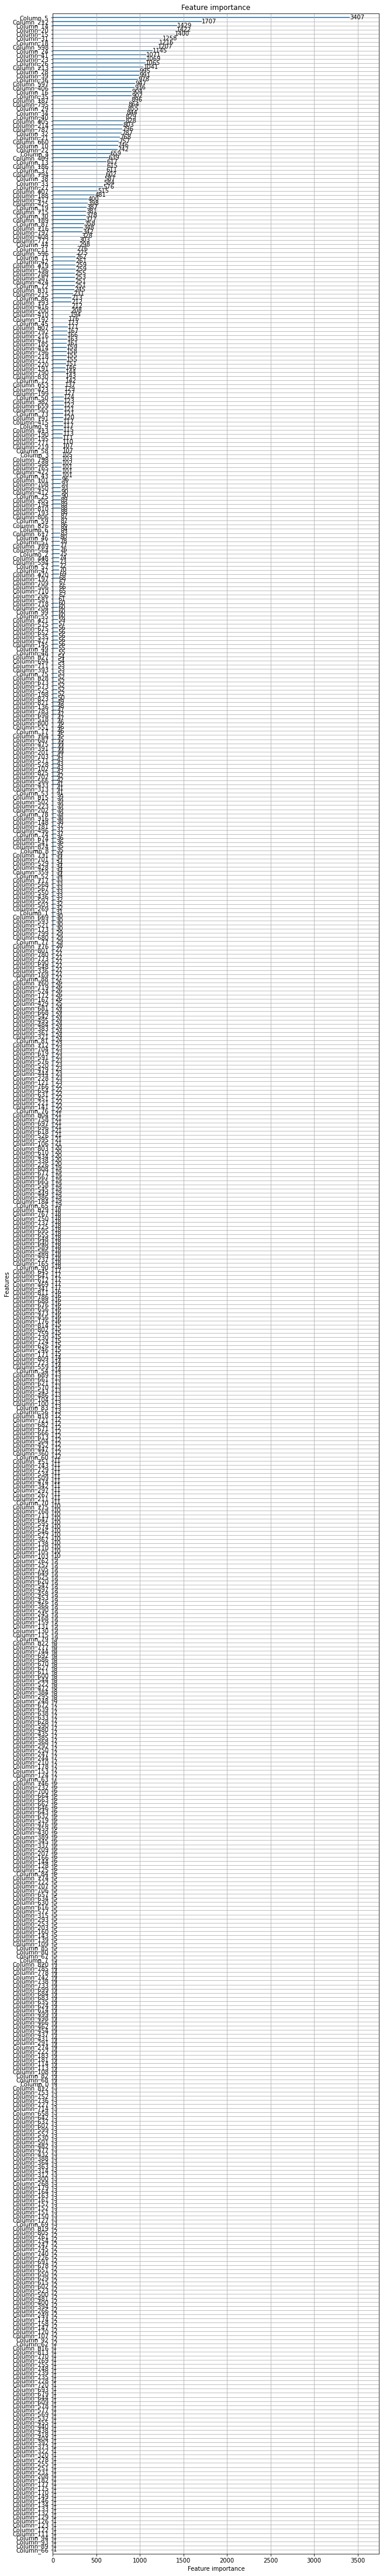

In [55]:
fig, ax = plt.subplots(figsize=(10, 80))
lgb.plot_importance(model.base_models[5], importance_type="split", ax=ax)

In [ ]:
vl = train.iloc[vl_idx]

In [ ]:
vl["preds"] = process_preds(vl_preds)

In [ ]:
#vl.loc[vl.days_to_enddate < 40*30.4].head()

In [ ]:
import shap

In [ ]:
vl.sample(10)

In [347]:
x3[567, -8:]

array([   4.,  299., -999.,    2.,    0.,    3., -999., -999.])

In [ ]:
#you 106876

In [422]:
train.loc[train.ID == 56070]

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month,days_to_enddate,days_from_start,ACCT-TYPE,ownership,status,disbursed_bur,CLOSE-DT,DISBURSED-DT
52260,56070,1.0,Arrear,Closed,Billed,147,INDORE,20,555000,300000.0,300000.0,85500.0,2011-10-31,2013-06-15,2011-10-31,2889979,1046,29421,54.05,M,50.0,25000.0,INDORE,MADHYA PRADESH,453441.0,> 48 Months,3319,334,Business Loan Priority Sector Agriculture,Individual,Closed,300000.0,2013-06-26,2011-10-31


In [418]:
bureau.loc[bureau.ID == 56070]

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE,DisbursalDate,Tenure,DisbursalAmount,AssetCost,EMI,MonthlyIncome,MaturityDAte,ZiPCODE,Area,State,DISBURSED-DT2,post_days,close_days,days_to_enddate,post_end_days_diff,frequency,installment,interest,installment_pm,post_days_diff,cur_bal_int,max_diff,min_diff,min_diff_loc,min_diff_date,max_diff_loc,max_diff_date,days_to_max_diff
281058,56070,True,PRIMARY,Business Loan Priority Sector Agriculture,NBF,2013-06-30,Individual,Closed,2011-10-31,2013-06-26 00:00:00,NaN,NaN,300000.0,NaN,0.0,NaN,0.0,0.0,NaN,"20130630,20130531,20130430,20130331,20130228,2...",0000000000000000000000000000000000000000000000...,"0,84411,83335,82273,81224,80189,79167,162568,1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",",,,,,,,,,,,,,,,,,,,,,,",NaN,2011-10-31,20,300000.0,555000,85500.0,25000.0,2013-06-15,453441.0,INDORE,MADHYA PRADESH,2011-10-31,0.0,604.0,3319.0,3319.0,NaN,NaN,NaN,NaN,False,"[300000, 301937, 220336, 223181, 226063, 22898...",2995,-84411,19,2013-04-30,6,2012-05-31,213.0
281059,56070,False,PRIMARY,Tractor Loan,PRB,2017-09-30,Joint,Closed,2013-08-31,2017-09-06 00:00:00,2017-09-04,NaN,456185.0,NaN,0.0,NaN,0.0,0.0,NaN,"20170930,20170831,20170731,20170630,20170531,2...",0000000000260000000000000000270000000000000000...,"0,2,2,79302,72710,72710,72710,72710,72710,1520...","0,0,0,79300,0,0,0,0,0,79300,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,2011-10-31,20,300000.0,555000,85500.0,25000.0,2013-06-15,453441.0,INDORE,MADHYA PRADESH,2014-12-31,670.0,2137.0,2649.0,1979.0,NaN,NaN,NaN,NaN,False,"[307921, 307921, 307921, 307921, 307921, 30792...",12636,-79300,24,2016-11-30,23,2016-12-31,1888.0
281060,56070,False,PRIMARY,Tractor Loan,PRB,2017-01-31,Individual,Closed,2014-05-08,2017-01-25 00:00:00,2017-01-11,NaN,354907.0,NaN,0.0,NaN,0.0,0.0,NaN,"20170131,20161231,20161130,20161031,20160930,2...",0000270000000000000000000000000000000000000000...,"0,74260,67848,67848,67848,67848,67848,67848,12...","0,74260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,2011-10-31,20,300000.0,555000,85500.0,25000.0,2013-06-15,453441.0,INDORE,MADHYA PRADESH,2014-12-31,920.0,1913.0,2399.0,1479.0,NaN,NaN,NaN,NaN,False,"[238224, 238224, 238224, 238224, 238224, 23822...",6412,-74260,24,2016-11-30,23,2016-12-31,1888.0
281061,56070,False,PRIMARY,Tractor Loan,PRB,2019-12-31,Individual,Closed,2017-01-25,2019-12-23 00:00:00,2019-12-05,NaN,353623.0,NaN,0.0,NaN,0.0,0.0,NaN,"20191231,20191130,20191031,20190930,20190831,2...",000000000000000000DDDDDD000DDD000000000000000D...,"0,73635,73635,73635,73635,73635,,,139760,,1397...","0,0,0,0,0,0,,,0,,0,0,0,0,0,,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,2011-10-31,20,300000.0,555000,85500.0,25000.0,2013-06-15,453441.0,INDORE,MADHYA PRADESH,2017-01-31,1913.0,2975.0,1406.0,-507.0,NaN,NaN,NaN,NaN,False,"[353623, 353623, 353623, 353623, 353623, 30034...",0,-73635,34,2019-10-31,0,2017-02-28,1947.0
281062,56070,False,PRIMARY,Kisan Credit Card,NAB,2020-01-31,Individual,Active,2017-09-11,NaN,NaN,NaN,479000.0,NaN,470700.0,NaN,NaN,0.0,Standard,"20200131,20191231,20191130,20191031,20190930,2...",XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"470700,470700,469878,469878,470011,470011,4509...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,",",,,133,,,,,,,8753,,,,,,434000,,,,,,,,,,,,,",NaN,2011-10-31,20,300000.0,555000,85500.0,25000.0,2013-06-15,453441.0,INDORE,MADHYA PRADESH,2017-09-30,2142.0,NaN,1177.0,-965.0,NaN,NaN,NaN,NaN,False,"[395000, 395000, 395000, 396300, 396300, 39630...",32817,-6158,17,2019-01-31,10,2018-08-31,2496.0
281063,56070,False,PRIMARY,Tractor Loan,PRB,2020-01-31,Individual,Active,2019-12-23,NaN,NaN,NaN,324587.0,NaN,324

In [268]:
bureau.loc[bureau.ID == 56070, 'CUR BAL - HIST'].values[1].split(",")

['0',
 '2',
 '2',
 '79302',
 '72710',
 '72710',
 '72710',
 '72710',
 '72710',
 '152010',
 '139374',
 '139374',
 '139374',
 '139374',
 '139374',
 '139374',
 '200497',
 '200497',
 '200497',
 '200497',
 '200497',
 '200497',
 '256538',
 '256538',
 '256538',
 '256538',
 '256538',
 '256538',
 '307921',
 '307921',
 '307921',
 '307921',
 '307921',
 '307921',
 '']

In [271]:
bureau.loc[bureau.ID == 56070, 'REPORTED DATE - HIST'].values[1].split(",")

['20170930',
 '20170831',
 '20170731',
 '20170630',
 '20170531',
 '20170430',
 '20170331',
 '20170228',
 '20170131',
 '20161231',
 '20161130',
 '20161031',
 '20160930',
 '20160831',
 '20160731',
 '20160630',
 '20160531',
 '20160430',
 '20160331',
 '20160229',
 '20160131',
 '20151231',
 '20151130',
 '20151031',
 '20150930',
 '20150831',
 '20150731',
 '20150630',
 '20150531',
 '20150430',
 '20150331',
 '20150228',
 '20150131',
 '20141231',
 '']

In [96]:
412-178

234

In [556]:
bur.loc[bur.ID == 1]

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,"37,352",NaN,"37,873",NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,"44,000","1,405/Monthly","20,797",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaN,NaN,"1,45,000",NaN,"1,16,087",NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,NaN,NaN,"3,00,000",NaN,0,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,NaN,NaN,"2,75,000",NaN,0,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
5,1,False,PRIMARY,Credit Card,NAB,2018-04-30,Individual,Closed,2018-01-11,2018-03-13 00:00:00,NaN,"50,000",0,NaN,0,NaN,NaN,0.0,Standard,"20180331,20180228,20180131,",000000000,"24650,17300,0,",",,,",",,,,",NaN
6,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-11-15,NaN,2019-12-15,NaN,"5,00,000","7,934/Monthly","4,43,769",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",000000000000000000000000000000000000000000,"443769,448365,453134,457687,462320,466802,4712...",",,,,,,,,,,,,,,",",,,,,,,,,,,,,,",84.0
7,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-01-30,2017-09-21 00:00:00,NaN,NaN,"5,00,000",NaN,0,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0000000000000870540270270000320000000000...,"0,,0,0,0,0,0,0,0,13060,13060,25982,38767,51417...","0,,0,0,0,0,3064,3064,3064,2972,0,2802,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
8,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-07-31,Individual,Closed,2013-06-11,2017-07-01 00:00:00,NaN,NaN,"4,00,000",NaN,0,NaN,0,0.0,NaN,"20170731,20170601,20170531,20170430,20170331,2...",000DDD0220210220190220220000270000000000000000...,"0,,0,10487,20862,31126,41281,51328,51328,71101...","0,,1722,1722,1722,1722,1722,1722,0,1625,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN


In [559]:
train.loc[(train.DisbursalDate == '2013-09-27') & (train.DisbursalAmount == 300000)]

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month,days_to_enddate
3963,4399,Half Yearly,Arrear,Closed,PDC,125,GUNA,36,525000,300000.0,300000.0,10000.0,2013-09-27,2016-06-10,2013-09-28,12813615,1046,25094,55.24,M,30.0,16666.67,ASHOK NAGAR,MADHYA PRADESH,473446.0,No Top-up Service,2594
4329,4804,Monthly,Arrear,Closed,Billed,3,JABALPUR,36,480000,300000.0,300000.0,10700.0,2013-09-27,2016-10-05,2013-09-27,12811920,1019,70715,62.50,M,19.0,68333.33,KATNI,MADHYA PRADESH,483770.0,No Top-up Service,2594
8618,9292,Half Yearly,Arrear,Closed,Direct Debit,330,VIDISHA,36,490000,300000.0,300000.0,63400.0,2013-09-27,2016-06-10,2013-09-27,12813231,1568,31014,48.29,M,36.0,16253.33,SAGAR,MADHYA PRADESH,470226.0,No Top-up Service,2594
19034,20396,Quatrly,Arrear,Closed,Billed,273,LUCKNOW,36,460000,300000.0,300000.0,34000.0,2013-09-27,2016-09-10,2013-09-27,12811916,1568,81942,57.83,M,23.0,71166.67,BUDAUN,UTTAR PRADESH,243631.0,No Top-up Service,2594
24377,26345,Half Yearly,Arrear,Closed,ECS,334,MANGALORE,36,583011,300000.0,300000.0,64180.0,2013-09-27,2016-08-10,2013-09-27,12810028,1060,37397,40.45,M,62.0,20833.33,SHIMOGA,KARNATAKA,577423.0,No Top-up Service,2594
26954,28971,Half Yearly,Arrear,Closed,ECS,93,NELLORE,36,510000,300000.0,300000.0,65950.0,2013-09-27,2016-09-10,2013-09-27,12810328,1186,23372,45.89,M,49.0,41666.67,PRAKASAM,ANDHRA PRADESH,523115.0,No Top-up Service,2594
36746,39209,Half Yearly,Arrear,Closed,PDC,59,GANDHIDHAM,48,490000,300000.0,300000.0,53100.0,2013-09-27,2017-10-05,2013-09-27,12813009,1060,69531,50.39,M,66.0,98750.00,KACHCHH,GUJARAT,370020.0,No Top-up Service,2594
59283,64228,Half Yearly,Arrear,Closed,PDC,199,SIRSA,36,503000,300000.0,300000.0,63050.0,2013-09-27,2016-06-10,2013-09-27,12813177,1062,20793,47.11,M,34.0,41000.00,HISAR,HARYANA,125011.0,No Top-up Service,2594
62497,67620,Half Yearly,Arrear,Closed,Direct Debit,308,INDORE,36,590000,300000.0,300000.0,80000.0,2013-09-27,2016-06-10,2013-09-28,12813430,1187,53912,37.29,M,26.0,67100.00,DEWAS,MADHYA PRADESH,455459.0,No Top-up Service,2594
69470,76317,Half Yearly,Arrear,Closed,ECS,246,BIKANER,36,590000,300000.0,300000.0,62100.0,2013-09-27,2016-06-10,2013-09-27,12813141,1046,40124,40.32,M,43.0,82000.00,BIKANER,RAJASTHAN,334604.0,> 48 Months,2594


In [555]:
np.diff(np.array(bur.loc[bur.ID == 143184, 'CUR BAL - HIST'].values[2].split(",")[:-1][::-1]).astype(int))

array([     0,  -9221, -10742, -10904, -11071, -11239, -11409, -23343,
            0, -11939, -12120, -12304, -12492, -12681])

In [545]:
bur.loc[bur.ID == 143184, 'REPORTED DATE - HIST'].values

array(['20160409,20160311,',
       '20191231,20191130,20191031,20190930,20190831,20190731,20190630,20190531,20190430,20190331,20190228,20190131,',
       '20200131,20191231,20191130,20191031,20190930,20190831,20190731,20190630,20190531,20190430,20190331,20190228,20190131,20181231,20181130,'],
      dtype=object)

In [ ]:
# hypothesis --> close date doesn't match - maturity date
# overdue during tenure